In [39]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional
# dataset = load_dataset("huggingface/cats-image")
dataset = load_dataset("cats_vs_dogs", revision="main")
# image = dataset["test"]["image"][0]
image = dataset["train"]["image"][6]
img_tensor = transforms.ToTensor()(image)

""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.
    
"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module=img_tensor,
                          input_image: Image=image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)
    
    
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

Found cached dataset cats_vs_dogs (/home/amir/.cache/huggingface/datasets/cats_vs_dogs/default/1.0.0/d4fe9cf31b294ed8639aa58f7d8ee13fe189011837038ed9a774fde19a911fcb)
100%|██████████| 1/1 [00:00<00:00, 409.28it/s]


Found cached dataset cats_vs_dogs (/home/amir/.cache/huggingface/datasets/cats_vs_dogs/default/1.0.0/d4fe9cf31b294ed8639aa58f7d8ee13fe189011837038ed9a774fde19a911fcb)
100%|██████████| 1/1 [00:00<00:00, 504.61it/s]


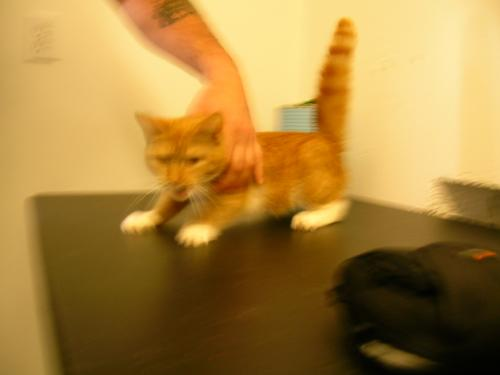

In [38]:
# dataset = load_dataset("huggingface/cats-image")
dataset = load_dataset("cats_vs_dogs", revision="main")
dataset["train"]["image"][0]

In [43]:
from transformers import ResNetForImageClassification
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

# We will show GradCAM for the "Egyptian Cat" and the 'Remote Control" categories:
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian_cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote_control, remote"))]

# The last layer in the Resnet Encoder:
target_layer = model.resnet.encoder.stages[-1].layers[-1]

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=None)))
print_top_categories(model, img_tensor)

KeyError: 'Egyptian_cat'

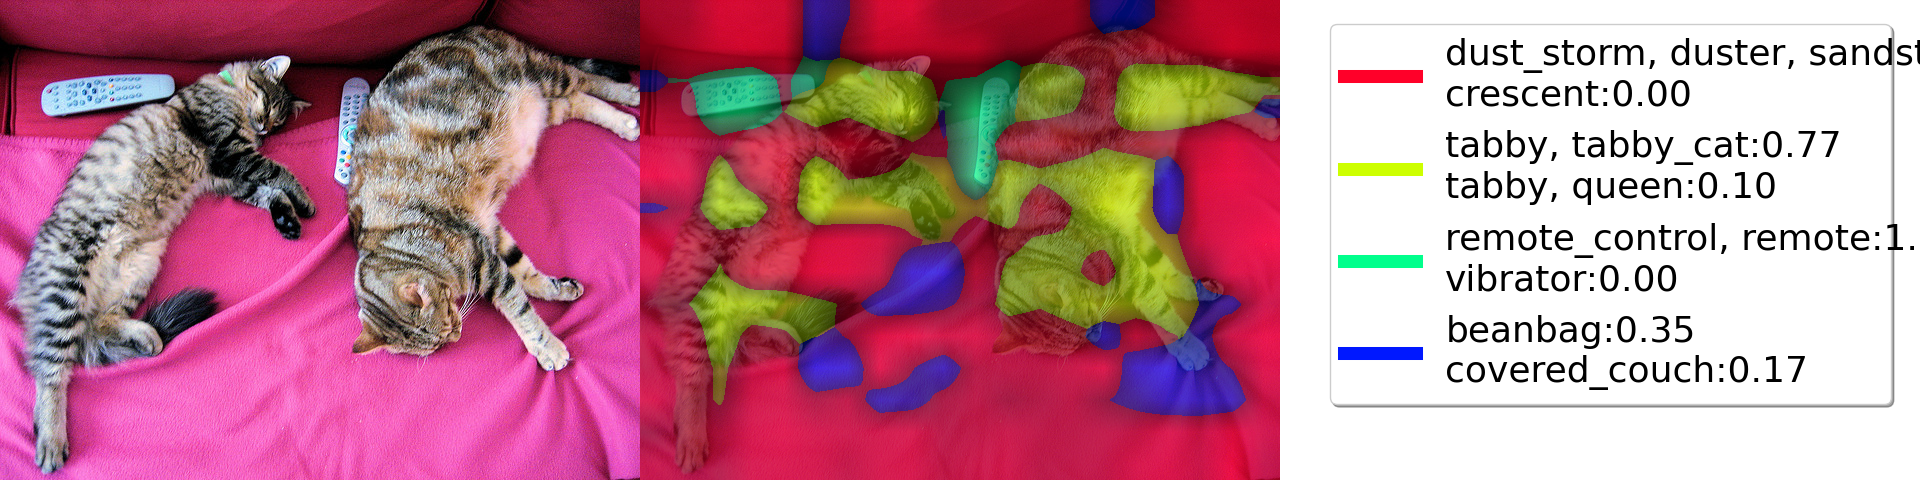

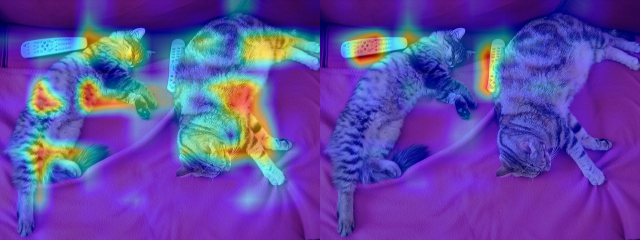

Predicted class 2397: tabby, tabby_cat
Predicted class 2395: tabby, queen
Predicted class 2388: domestic_cat, house_cat, Felis_domesticus, Felis_catus
Predicted class 2398: tiger_cat
Predicted class 2405: Egyptian_cat


In [16]:
from transformers import SwinForImageClassification
from functools import partial
def swinT_reshape_transform_huggingface(tensor, width, height):
    result = tensor.reshape(tensor.size(0),
                            height,
                            width,
                            tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

model = SwinForImageClassification.from_pretrained("microsoft/swin-large-patch4-window12-384-in22k")
target_layer = model.swin.layernorm
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian_cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote_control, remote"))]
img_tensor.shape
reshape_transform = partial(swinT_reshape_transform_huggingface,
                            width=img_tensor.shape[2]//32,
                            height=img_tensor.shape[1]//32)

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=reshape_transform,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=reshape_transform)))
print_top_categories(model, img_tensor)

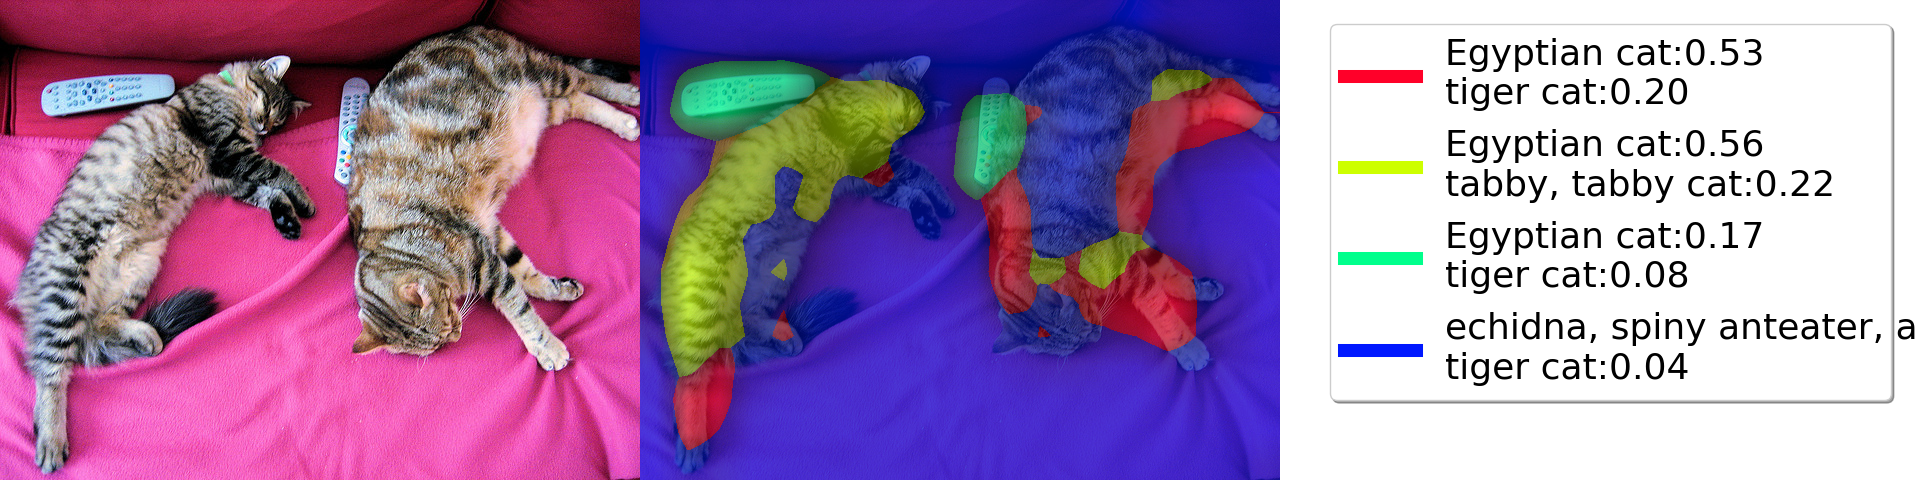

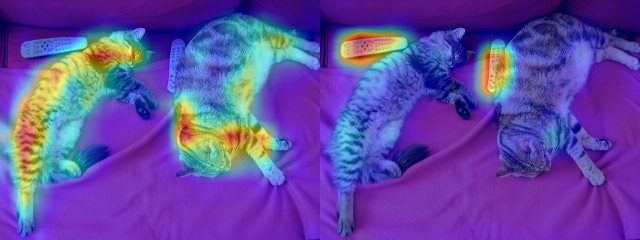

Predicted class 285: Egyptian cat
Predicted class 281: tabby, tabby cat
Predicted class 282: tiger cat
Predicted class 287: lynx, catamount
Predicted class 283: Persian cat


In [17]:
from transformers import SegformerForImageClassification
from functools import partial
def segformer_reshape_transform_huggingface(tensor, width, height):
    result = tensor.reshape(tensor.size(0),
                            height,
                            width,
                            tensor.size(2))
    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result
reshape_transform = partial(segformer_reshape_transform_huggingface,
                            width=img_tensor.shape[2]//32,
                            height=img_tensor.shape[1]//32)

model = SegformerForImageClassification.from_pretrained("nvidia/mit-b0")
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]
target_layer = model.segformer.encoder.layer_norm[-1]

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=reshape_transform,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=reshape_transform)))
print_top_categories(model, img_tensor)

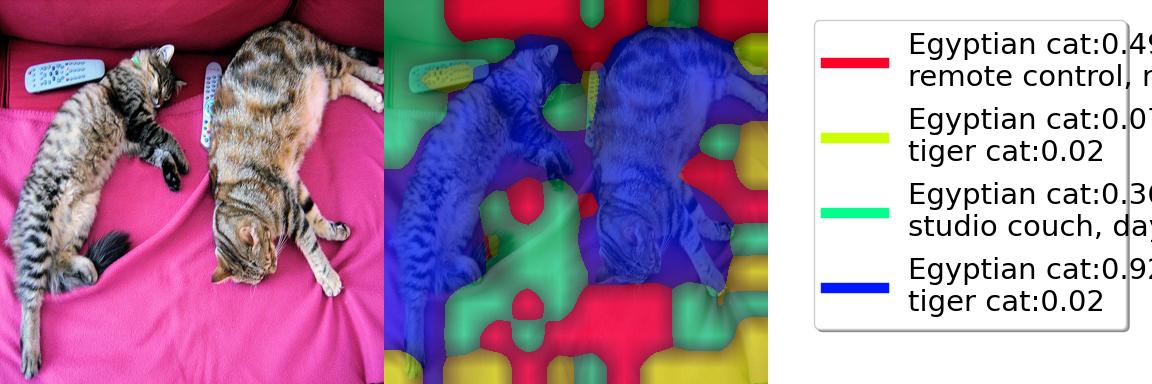

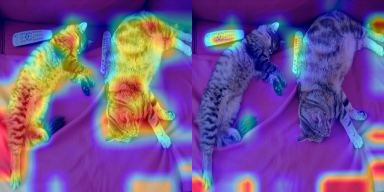

Predicted class 285: Egyptian cat
Predicted class 282: tiger cat
Predicted class 281: tabby, tabby cat
Predicted class 761: remote control, remote
Predicted class 287: lynx, catamount


In [18]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0],
                                   12, 12, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384')
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]
target_layer_dff = model.vit.layernorm
target_layer_gradcam = model.vit.encoder.layer[-2].output
image_resized = image.resize((384, 384))
tensor_resized = transforms.ToTensor()(image_resized)


display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer_dff,
                          classifier=model.classifier,
                          img_pil=image_resized,
                          img_tensor=tensor_resized,
                          reshape_transform=reshape_transform_vit_huggingface,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer_gradcam,
                      targets_for_gradcam=targets_for_gradcam,
                      input_tensor=tensor_resized,
                      input_image=image_resized,
                      reshape_transform=reshape_transform_vit_huggingface)))
print_top_categories(model, tensor_resized)